# Prática 5 - Pré-Processamento

#Nome: Ricardo França Fernandes do Vale     No. USP: 9293477

Nesta prática, ocorrerá mais uma etapa de pré-processamento, que, em contraposição às técnicas anteriores que visavam redução de dimensões e valores faltantes, será utilizada para o balanceamento de distribuição de classes diante do conjunto de dados por completo, para realização de conversões de valores de atributos para melhorar a performance da classificação e para a normalização de dados. Ou seja, o pré-processamento será pensando diante dos valores dos atributos individualmente e em relação à distribuição das classes no dataset.


## Dataset - Breast Cancer

Devido ao fato de que esse pré-processamento tem em vista executar um algoritmo de classificação, o dataset de interesse foi modificado para um dataset com classes discretas: o dataset Breast Cancer, que, diante de alguns fatores biológicos (atributos) tem como alvo classificar a amostra como tumor benigno ou maligno. Primeiramente, será carregado o dataset:

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data = pd.DataFrame(data=np.c_[data['data'], data['target']], 
                          columns=np.r_[data['feature_names'], ['target']])
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


### 1. Desbalanceamento, subamostragem e superamostragem

A primeira verificação que será feita é a distribuição de classe por objetos no dataset.

In [28]:
print('Distribuição de classes original')
print(data.iloc[:, [0,-1]].groupby('target').count())

Distribuição de classes original
        mean radius
target             
0.0             212
1.0             357


É possível constatar que existem 212 amostras classificadas como tumor maligno (classe 0) e 357 como tumor benigno (classe 1).

O próximo passo é aplicar técnicas para fazer os processos de tratamento do desebalanceamento: ou com subamostragem ou com superamostragem. Primeiramente, devemos observar a distribuição original das classes no dataset.

In [31]:
total = len(data)

# dicionario com a probabilidade das classes
probs = {0: 212/total, 1: 357/total}
probs

{0: 0.37258347978910367, 1: 0.6274165202108963}

Em seguida, será aplicada uma função de amostragem, em que a ideia é tornar a probabilidade de ocorrência das duas classes similar. O que é feito no processo abaixo, onde realiza-se a escolha de probabilidade igual para ambas as classes, a subamostragem com 200 objetos para cada classe e a superamostragem com 400 objetos para cada classe.

In [32]:
#abordagem para probabilidade igual para as classes
probs = {0: 1/2, 1: 1/2}
sample_probs = data.target.copy()
for c in data.target.unique():
    sample_probs[sample_probs == c] = probs[c]
data1 = data.sample(frac=1, replace=True, weights=sample_probs)
print('\nDistribuição de classes amostrada com probs iguais')
print(probs)
print(data1.iloc[:, [0,-1]].groupby('target').count())

#abordagem para realizar a subamostragem
data2 = [data.loc[data.target == c, :].sample(n=200, replace=True) for c in data.target.unique()]
print('\n\nFixando o número de exemplos por classe em 200')
data2 = pd.concat(data2)
print(data2.iloc[:, [0,-1]].groupby('target').count())

#abordagem para realizar a superamostragem
data3 = [data.loc[data.target == c, :].sample(n=400, replace=True) for c in data.target.unique()]
print('\n\nFixando o número de exemplos por classe em 400')
data3 = pd.concat(data3)
print(data3.iloc[:, [0,-1]].groupby('target').count())


Distribuição de classes amostrada com probs iguais
{0: 0.5, 1: 0.5}
        mean radius
target             
0.0             207
1.0             362


Fixando o número de exemplos por classe em 200
        mean radius
target             
0.0             200
1.0             200


Fixando o número de exemplos por classe em 400
        mean radius
target             
0.0             400
1.0             400


Dada essa nova distribuição, o próximo passo é executar o algoritmo de classificação abaixo neste dataset. O algoritmo deve ter como um parâmetro a configuração dos pesos das classes no dataset, a fim de balancear a distribuição de uma forma diferente. A execução ocorrerá nos datasets com subamostragem e superamostragem acima e no dataset original com mudança de peso.

Abaixo há o algoritmo de classificação utilizado no processo.

In [33]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def classificacao(data, columns, target, weights):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    weights:    Dicionário. Pesos das classes, cada chave do dicionário é a classe e seu valor a probabilidade
    ---------------------------------------------------------------
    Realiza a classificação em 3 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6, class_weight=weights)
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6, class_weight=weights)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1), class_weight=weights)
    
    clfs = [svm_l, svm_n, dt]
    clfs_names = ['svm_linear', 'svm_poly', 'dt']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - acurácia'
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


Classificação do dataset com subamostragem
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
30


/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


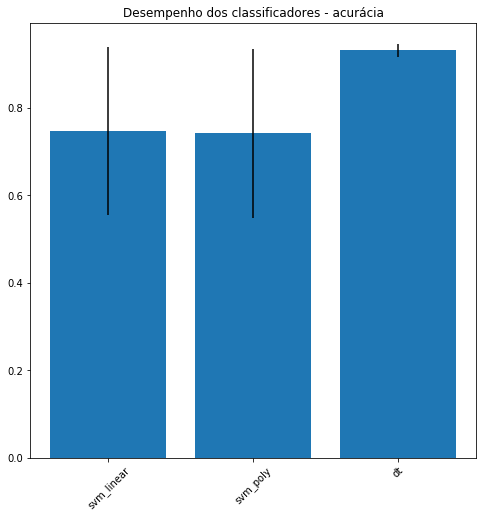

Classificação do dataset com superamostragem
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
30


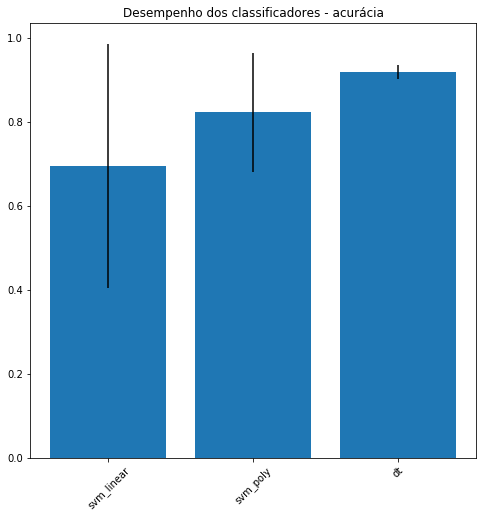

In [37]:
# Classificação do dataset com subamostragem
print('Classificação do dataset com subamostragem')
target = len(data2.columns) -1
columns = list(range(target))
print(columns)
print(target)

clf = classificacao(data2, columns, target, weights={0:0.5, 1:0.5})

# Classificação do dataset com superamostragem
print('Classificação do dataset com desbalanceamento forçado')
target = len(data3.columns) -1
columns = list(range(target))
print(columns)
print(target)

clf = classificacao(data3, columns, target, weights={0:0.5, 1:0.5})

Após a classificação ser feita nos datasets subamostrado e superamostrado, a classificação será feita no dataset original com a mudança de pesos para dois cenários:
 - Probabilidades de ocorrẽncia entre classes invertidas;
 - Probabilidade 1 para a classe de maior ocorrência e 0 para a de menor ocorrência;
 - Probabilidade 0 para a classe de maior ocorrência e 1 para a de menor ocorrência.

Classificação do dataset com probabilidades de ocorrência inversas


/home/ricardoffv/.local/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


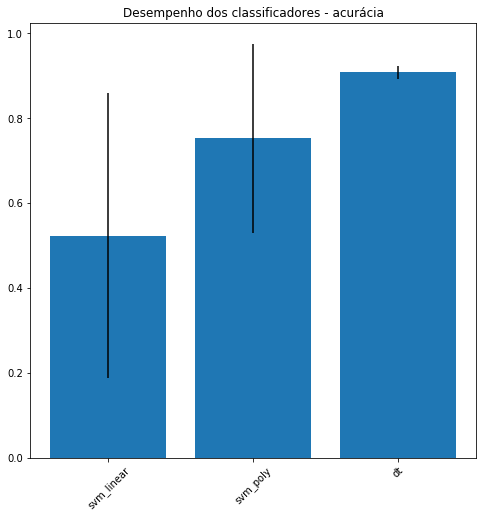

Classificação do dataset com desbalanceamento forçado p(1)=1


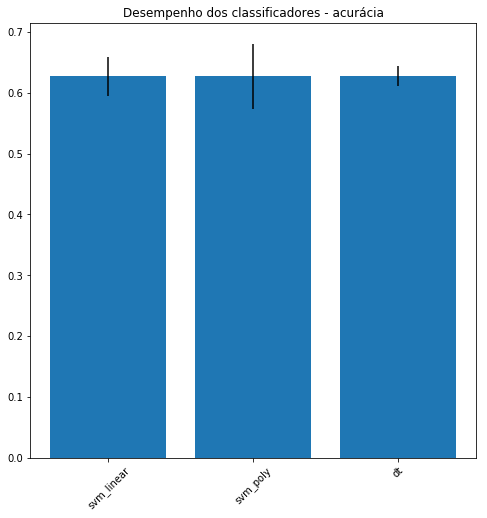

Classificação do dataset com desbalanceamento forçado p(0)=1


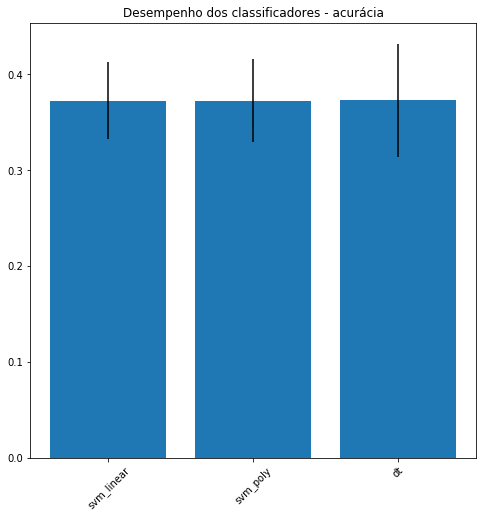

In [39]:
# Probabilidades inversas
print('Classificação do dataset com probabilidades de ocorrência inversas')
target = len(data.columns) -1
columns = list(range(target))

clf = classificacao(data, columns, target, weights={0: 0.6274165202108963, 1: 0.37258347978910367})

# Classificação do dataset com Probabilidade 1 para a classe de maior ocorrência e 0 para a de menor ocorrência.
print('Classificação do dataset com desbalanceamento forçado p(1)=1')
clf = classificacao(data, columns, target, weights={0:0, 1:1})

# Classificação do dataset com Probabilidade 0 para a classe de maior ocorrência e 1 para a de menor ocorrência.
print('Classificação do dataset com desbalanceamento forçado p(0)=1')
clf = classificacao(data, columns, target, weights={0:1, 1:0})

**Conclusões:** Analisando os dados, pode-se inferir que:
- A subamostragem auxiliou no processo de classificação, dados os pesos 0.5 para cada classe; no entanto, a superamostragem produziu uma queda de acurácia, talvez devido ao fato de utilizar atributos copiados dos existentes para popular as amostras (segundo o comportamento teórico da técnica);
- O desbalanceamento forcado auxilia muito na classificação, principalmente quando força as classes de menor incidência a serem mais frequentes;
- Na classificação sum_linear o comportamento foi um pouco inesperado ao tentar balancear os dados invertendo as proporções dos objetos de acordo com a classe, o que se contrapõe ao desempenho do algoritmo dt, que produziu uma das melhores acurácias para tal configuração. Este acontecimento só reforça o fato de que a escolha do algoritmo deve ser baseada na observação do espaço dos dados. 

### 2. Conversão de valores nos atributos

Serão escolhidos **dois** atributos dentre os 30, que indicam números reais, para ser realizada conversão de valores. No caso, só seria possível realizar conversões dos dados quantitativos para qualitativos, o que acarreta em modificações em relação a abordagem de classificação, dependendo de como ela ocorrer (por exemplo, usar classificação baseada em distância, que pararia de ser aplicada a valores nominais).

A escolha dos atributos foi baseada tanto no caráter do problema, quanto no fato de que a escolha desses atributos deveria ser boa para a classificação, que pode ter um espaço de dados melhor caso sejam encontrados valores com menor variação de dados, principalmente ao convertê-los para nominais (árvores de decisão, por exemplo, se classificadoras deste dataset teriam menos ramificações para adentrar e enviesar o processo). Por isso, abaixo está plotado o histograma de todos os atributos considerados como média, tendo em vista que eles possuem os valores com maior significância (semântica) que os valores taxados como worst e error.

A intenção é observar dados que se distanciem de uma distribuição normal e possuam um intervalo de valores não muito grande.

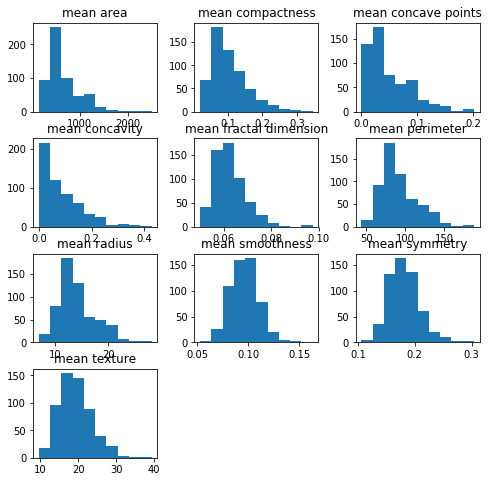

In [44]:
data.iloc[:,0:10].hist(figsize=(8,8),grid=False)
plt.show()

Sendo assim, **os atributos escolhidos são *mean_compactness* e *mean_concavity*.** Isso se deve ao fato de que a distribuição não aparenta ser normal em ambos os casos e devido ao pequeno intervalo que apresentam. Será plotado o boxplot dos dois atributos para verficar a abordagem a ser tomada na conversão para valores qualitativos.

Boxplot de mean compactness


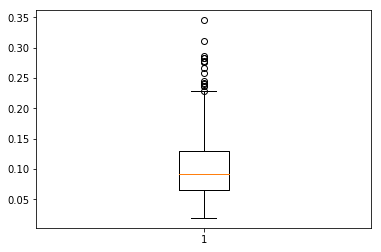

Boxplot de mean concavity


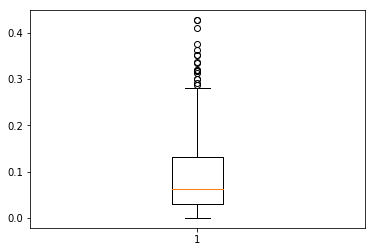

In [47]:
print('Boxplot de mean compactness')
plt.boxplot(data['mean compactness'])
plt.show()
print('Boxplot de mean concavity')
plt.boxplot(data['mean concavity'])
plt.show()

Dado o boxplot podemos observar melhor a distribuição dos dados para categorizá-los. A reatribuição de valores ocorrerá de maneira similar para cada atributo utilizando a abordagem de rotular por meio de quartis.

Em mean_compactness e mean_concavity:
    * Valores em Q2: low;
    * Valores entre Q2 e Q3: medium;
    * Valores entre Q3 e máximo do intervalo do boxplot: high;
    * Outliers: very high;

In [95]:
conv_data = data.copy()

#Conversão de valores - mean compactness
q2 = conv_data['mean compactness'].quantile(q=0.5)
q3 = conv_data['mean compactness'].quantile(q=0.75)
max_boxplot = conv_data['mean compactness'].quantile(q=0.975)

conv_data['mean compactness'] = conv_data['mean compactness'].astype(str)
for i in range(len(conv_data['mean compactness'])):
    if (float(conv_data['mean compactness'][i]) < q2): conv_data['mean compactness'][i] = "low"
    elif (float(conv_data['mean compactness'][i]) < q3): conv_data['mean compactness'][i] = "medium"
    elif (float(conv_data['mean compactness'][i]) < max_boxplot): conv_data['mean compactness'][i] = "high"
    else: conv_data['mean compactness'][i] = "very high"
        
#Conversão de valores - mean concavity
q2 = conv_data['mean concavity'].quantile(q=0.5)
q3 = conv_data['mean concavity'].quantile(q=0.75)
max_boxplot = conv_data['mean concavity'].quantile(q=0.975)

conv_data['mean concavity'] = conv_data['mean concavity'].astype(str)
for i in range(len(conv_data['mean concavity'])):
    if (float(conv_data['mean concavity'][i]) < q2): conv_data['mean concavity'][i] = "low"
    elif (float(conv_data['mean concavity'][i]) < q3): conv_data['mean concavity'][i] = "medium"
    elif (float(conv_data['mean concavity'][i]) < max_boxplot): conv_data['mean concavity'][i] = "high"
    else: conv_data['mean concavity'][i] = "very high"
        
conv_data.head()

/home/ricardoffv/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ricardoffv/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/ricardoffv/.local/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/ricardoffv/.local/lib/

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,very high,high,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,low,medium,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,high,high,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,very high,high,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,high,high,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


Uma sugestão posterior, para análises futuras seria transformar os atributos categóricos em atributos binários para obterem o formato de código cinza.

### 3. Normalização de valores

Observando os histogramas plotados anteriormente, podemos observar alguns atributos cujo intervalo de dados é muito pequeno, sendo estes de nosso interesse para normalizar: ***mean fractal dimension* e *mean smoothness***.

Mean fractal dimension será normalizado para valores [0,1] e mean smoothness será normalizado com z-score, devido à proximidade que o seu histograma tem de uma distribuição normal padrão, observando graficamente.

Mean fractal dimension


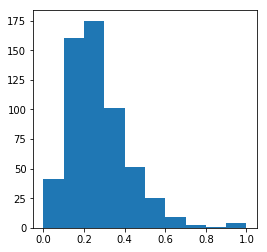

Mean smoothness


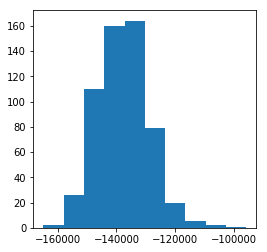

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,-123905.913377,very high,high,0.14710,0.2419,0.605518,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,-144842.214661,low,medium,0.07017,0.1812,0.141323,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,-129379.456197,high,high,0.12790,0.2069,0.211247,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,-108915.869974,very high,high,0.10520,0.2597,1.000000,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,-135163.995767,high,high,0.10430,0.1809,0.186816,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [103]:
#Utilizaremos conv_data para obter os dados normalizados
fd = 'mean fractal dimension'
sm = 'mean smoothness'

# mean fractal dimension
max_fd = conv_data[fd].max()
min_fd = conv_data[fd].min()
conv_data[fd] = (conv_data[fd]-min_fd)/(max_fd - min_fd)

# mean smoothness
mean_sm = conv_data[fd].mean()
sigma_sm = conv_data[fd].std()
conv_data[sm] = (conv_data[sm]-mean_sm) / sigma_sm

# Plotando os histogramas novamente
print('Mean fractal dimension')
conv_data.iloc[:,9].hist(figsize=(4,4),grid=False)
plt.show()
print('Mean smoothness')
conv_data.iloc[:,4].hist(figsize=(4,4),grid=False)
plt.show()

conv_data.head()

**Conclusão:** A normalização teve grande impacto para alinhar os dados em uma distribuição normal para ambos os atributos, o que melhorou o intervalo de valores em mean fractal dimension, porém, criou um intervalo de dados muito grande em mean smoothness.